# Coursera Spacecraft Dynamics and Control - Kinematics
## Module 3
## Concept Check 20 - MRP Differential Kinematic Equation

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import sys

sys.path.append('../../')

import attitude_math as am

### Question 4 and 5 setup
Generic Differential Kinematic function for questions 4 and 5

In [23]:
def f(state, t, H_dot, I_inv):
    sigma = state[:3]
    omega = state[3:]

    sigma_dot = am.MRP_omega_DKE(sigma, omega)
    # Note in the below H_dot omega_R/N is zero and
    # the omega cross I*omega is cancelled
    omega_dot = I_inv @ H_dot
    state_dot = np.concatenate([sigma_dot, omega_dot])
    return state_dot

def Full_State_MRP_short_integrator(pdot,p0,t0,tf,dt):
    """
    Integrate quaternion rates to get new attitude quaternion
    """
    length=int((tf-t0)/dt)+1
    p=np.zeros([length,6])
    p[0,:]=np.array([p0])
    for i,t in enumerate(np.arange(t0, tf, dt)):
        p_new = p[i] + pdot(p[i],t).transpose()*dt
        p[i+1,:] = p_new
        p[i+1,:3] = am.MRP_short(p_new[:3])
    return p

## Question 4

Write software code to simulate the general spacecraft motion where a control torque $u$ is being applied. The principal inertias are $I_1 = 100 \, \text{kg m}^2$, $I_2 = 75 \, \text{kg m}^2$, and $I_3 = 80 \, \text{kg m}^2$. The initial states are 

$\sigma_{B/N}(t_0) = (0.1, 0.2, -0.1)$ 

and 

$\omega_{B/N}(t_0) = (30, 10, -20) \, \text{deg/sec}$. 

Use the globally asymptotically stabilizing control solution: 

$u = -K\sigma_{B/R} - [P]\omega_{B/R} + [I](\dot{\omega}_{R/N} - \omega_{B/N} \times \omega_{R/N}) + [\omega_{B/N}][I]\omega_{B/N} - L$ 

Use the gains $K = 5 \, \text{Nm}$ and $P = 10 \, \text{Nms}$ where $[P] = P[I_{3 \times 3}]$. For the following case, assume $L$ is zero.

Simulate a regulator case (i.e. reference frame is equal to inertial frame) for 120 seconds where $\sigma_{R/N}$ is the zero orientation. Enter below the MRP norm $\sqrt{\sigma_1^2 + \sigma_2^2 + \sigma_3^2}$ at 30 seconds into the simulation.

0.1949837663475891 [ 0.14039458  0.01253431 -0.13472535]


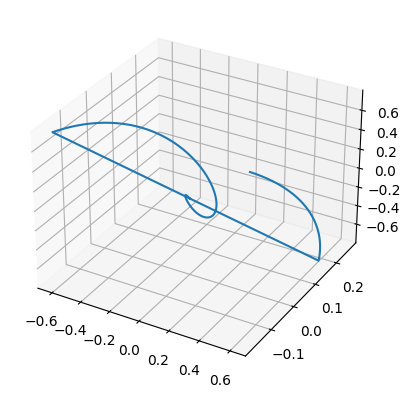

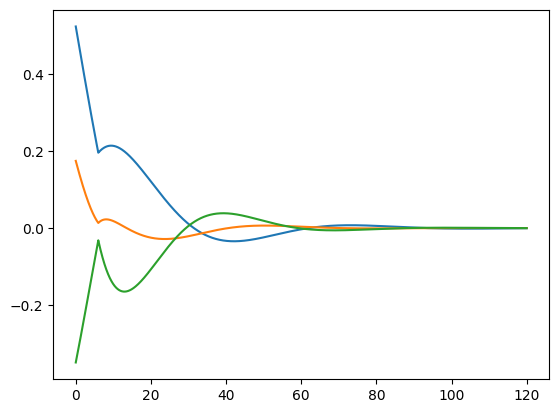

0


In [24]:
I = np.diag([100,75,80])
I_inv = np.linalg.inv(I)
K = 5
P = 10 * np.eye(3)

# H_dot with regulator cancellations for speed up
def H_dot(state, K ,P):
    sigma = state[:3]
    omega = state[3:]
    return - K * sigma - P @ omega

sigma_0 = np.array([0.1, 0.2, -0.1])
omega_0 = np.deg2rad(np.array([30,10,-20]))
state_0 = np.concatenate([sigma_0,omega_0])

# Integrate the MRP differential kinematic equations
t_step = 0.005
dot = lambda state, t : f(state, t, H_dot(state, K, P), I_inv)
#state_t = scipy.integrate.odeint(dot, state_0, np.arange(0., 120., t_step))
state_t = Full_State_MRP_short_integrator(dot, state_0, 0., 120., t_step)

# Calculate the MRP norm squared
answer_i  = int(30/t_step)
print(np.linalg.norm(state_t[answer_i,:3]),state_t[answer_i,:3])
ax = plt.figure().add_subplot(projection='3d')
ax.plot(state_t[:,0], state_t[:,1], state_t[:,2])
plt.show()

plt.plot(list(np.arange(0., 120.+t_step, t_step)),state_t[:,3:])
plt.show()

print(np.sum(np.linalg.norm(state_t[:,:3],axis=1)>1))


In [25]:
print(state_t[-1])

[-1.02813030e-03  3.66198778e-05  5.42914716e-04 -3.72291170e-04
  4.62592680e-05 -8.86225843e-05]


### Question 5
Simulate an attitude tracking case for 120 seconds where $\sigma_{R/N}=(0.2\sin(ft),0.3\cos(ft),-0.3\sin(ft))$ with $f=0.05$ rad/sec. Enter below the MRP tracking error norm $|\sigma_{B/R}|$ at 40 seconds into the simulation.

0.1590008429563991 [-0.14582625 -0.0456291   0.04397679]


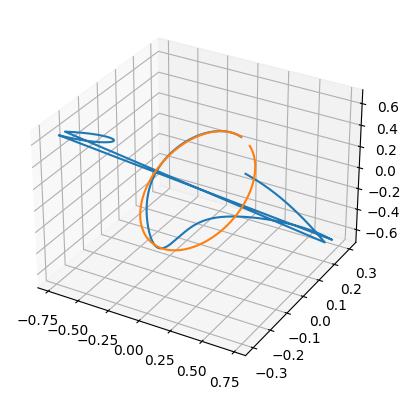

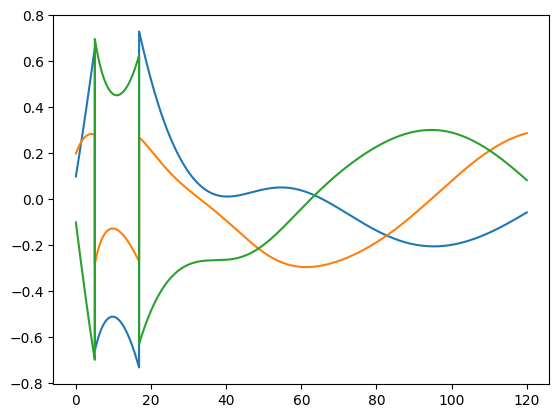

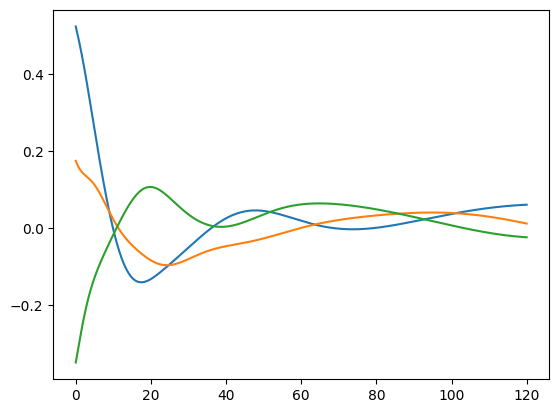

In [26]:
freq = 0.05
sigma_r = lambda t, f :  [0.2*np.sin(f*t), 0.3*np.cos(f*t), -0.3*np.sin(f*t)]
sigma_dot_r = lambda t, f : [0.2*f*np.cos(f*t), -0.3*f*np.sin(f*t), -0.3*f*np.cos(f*t)]

sigma = sigma_r(0, freq)
sigma_dot = sigma_dot_r(0, freq)
def state_r(t, f) : 
    sigma = sigma_r(t, f)
    sigma_dot = sigma_dot_r(t, f)
    omega_r = am.MRPdot_2_omega(sigma, sigma_dot)
    omega_r_old = am.MRPdot_2_omega(sigma_r(t-t_step, f), sigma_dot_r(t-t_step, f))
    omega_r_dot = (omega_r-omega_r_old)/t_step
    return np.concatenate([sigma, omega_r, omega_r_dot])

# H_dot with regulator cancellations for speed up
def H_dot(state, state_r, I, K, P):
    sigma = state[:3]
    omega = state[3:]
    #att_diff = am.MRP_diff(state_r[:3],sigma)
    att_diff = am.DCM_2_MRP(am.MRP_2_DCM(sigma)@am.MRP_2_DCM(state_r[:3]).transpose())
    omega_r_br = am.MRP_2_DCM(att_diff)@state_r[3:6]
    omega_rdot_br = am.MRP_2_DCM(att_diff)@state_r[6:]
    tracking_term = omega_rdot_br - np.cross(omega, omega_r_br)
    return -K * att_diff - P @ (omega - omega_r_br) + I@tracking_term

# Integrate the MRP differential kinematic equations
t_step = 0.005

dot = lambda state, t : f(state, t, H_dot(state, state_r(t, freq), I, K, P), I_inv)
#state_t = scipy.integrate.odeint(dot, state_0, np.arange(0., 120., t_step))
state_t = Full_State_MRP_short_integrator(dot, state_0, 0., 120., t_step)

# Calculate the MRP norm squared
answer_i  = int(40/t_step)+1
del_sigma = am.DCM_2_MRP(am.MRP_2_DCM(state_t[answer_i,:3])@am.MRP_2_DCM(sigma_r(40, freq)).transpose())
print(np.linalg.norm(del_sigma), del_sigma)
ax = plt.figure().add_subplot(projection='3d')
ax.plot(state_t[:,0], state_t[:,1], state_t[:,2])
sigma = np.array([sigma_r(t,freq) for t in np.arange(0., 120., t_step)])
sigma_dot = np.array([sigma_dot_r(t,freq) for t in np.arange(0., 120., t_step)])
ax.plot(sigma[:,0],sigma[:,1],sigma[:,2])
plt.show()

plt.plot(list(np.arange(0., 120.+t_step, t_step)),state_t[:,:3])
plt.show()

plt.plot(list(np.arange(0., 120.+t_step, t_step)),state_t[:,3:6])
plt.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter3d(x=state_t[:,0], y=state_t[:,1], z=state_t[:,2])
fig.add_scatter3d(x=sigma[:,0],y=sigma[:,1],z=sigma[:,2],)
fig.show()

[-0.05633258  0.28812241  0.08392992  0.06063776  0.01180157 -0.02396649]
[-0.05593111  0.28803012  0.08389666]
[ 0.009601    0.00419483 -0.01440151]


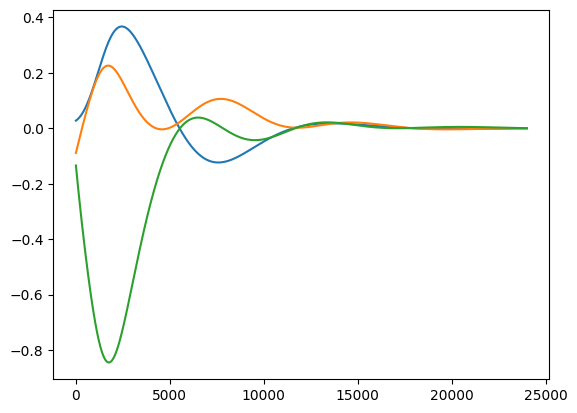

In [28]:
print(state_t[-1])
print(sigma[-1])
print(sigma_dot[-1])

diff = []
for i in range(len(state_t)):
    diff.append(am.MRP_diff(sigma[i],state_t[i,:3]))
plt.plot(diff)
plt.show()